In [1]:
# Install libraries required
# !pip install langchain --user
# !pip install pypdf
# !pip install pinecone-client
# !pip install openai
# !pip install tiktoken

Create Account on [OpenAI](https://platform.openai.com/) and [Pinecone](https://www.pinecone.io/) to get the API Key

In [50]:
# Load libraries
import os 
import pinecone
from langchain import OpenAI
from langchain.chains import RetrievalQA
from langchain.vectorstores import Pinecone
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [14]:
# Define secret API key and variable from above platforms
OPENAI_KEY = ""
PINECONE_KEY = ""
ENVIRONMENT_NAME = ""

In [15]:
# Set environment variable of OPENAI Key
os.environ["OPENAI_API_KEY"] = OPENAI_KEY

In [16]:
# Initialize pinecone
pinecone.init(
    api_key = PINECONE_KEY,
    environment = ENVIRONMENT_NAME
)

In [17]:
# Create index - Custom Knowledge Base.
loader = PyPDFLoader("dataset/UNIKOM_STHEVAN REYNALDO SIMAK LANDO_BAB II.pdf")
pages = loader.load_and_split()

In [18]:
# Split text from PDF into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 200,
    length_function = len,
)

docs = text_splitter.split_documents(pages)

In [19]:
# Create embedding based on OpenAIEmbedding technique
embeddings = OpenAIEmbeddings()

In [27]:
# Initialize document searching based on available index in Pinecone
index_name = "test-index"
docsearch = Pinecone.from_documents(docs, embeddings, index_name = index_name)

In [28]:
# define LLM and QA Object
llm = OpenAI(temperature=0.2)
qa = RetrievalQA.from_chain_type(
    llm = llm, 
    chain_type = "stuff", 
    retriever = docsearch.as_retriever(search_kwargs={"k": 2})
)

In [29]:
# Test Query based on our Custom Knowledge Base
query = "Apa itu LED?"
qa.run(query)

' LED adalah keluarga dioda yang terbuat dari bahan semikonduktor. Warna-warna cahaya yang dipancarkan oleh LED tergantung pada jenis bahan semikonduktor yang dipergunakannya. LED banyak dipakai untuk berbagai macam kebutuhan, seperti penggunaan lampu permainan untuk anak-anak, untuk trafic light, sebagai indikator pada peralatan elektronik hingga mesin industri, penggunaan pada lampu emergency, pada televisi, dan berbagai perangkat elektronik lainnya sebagai tanda bahwa sistem dalam keadaan.'

# Word Distribution Visualisation

In [39]:
# Load libraries
import re
import numpy as np
from random import choice
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

plt.style.use('ggplot')

In [40]:
# Define color_map function to generate similar color pallete on wordcloud
def color_map(word, *args, **kwargs):
    return choice(['#ABC9FF', '#FF8B8B', '#FF8B8B', '#BAD7E9'])

In [47]:
# Define stopwords from bahasa, sastrawi only has 126 kind of stopwords
stopwords_bahasa = StopWordRemoverFactory()
stopwords_bahasa = stopwords_bahasa.get_stop_words()

# Enrich stopwords with current dataset
stopwords_bahasa = stopwords_bahasa + [
    "merupakan", "versi", "ii",
    "tersebut"# We can put external stopwords if the word contains "non-semantic" meaning or create bias.
]

# Remove duplicate and convert list to tuple.
stopwords_bahasa = set(stopwords_bahasa)

In [48]:
# Create function to generate wordcloud
def generate_wordcloud(list_comment_words, title):
    comment_words = " ".join(list_comment_words)
    wordcloud = WordCloud(
        width = 800, height = 500,
        background_color ='white',
        stopwords = stopwords_bahasa,
        min_font_size = 10, 
        color_func = color_map
    ).generate(comment_words)
    
    plt.figure(figsize = (20, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontsize = 25, pad = 20)
    plt.tight_layout(pad = 0);
    
# Create function to clean sentence using RegEx
def regex_cleaning(sentence: str):
    """
    desc: remove characted and only allow alphabet & numerical in sentence
    """
    list_emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"   
        u"\U0001F680-\U0001F6FF"   
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
                      "]+", re.UNICODE)
    sentence = re.sub(list_emoji, '', sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = re.sub(r"http\S+", "", sentence).strip()
    sentence = re.sub(r"www\S+", "", sentence).strip()
    sentence = re.sub(r"[^a-zA-Z0-9]", " ", sentence)
    sentence = " ".join(list(map(lambda x: x.strip(), sentence.split()))).lower()
    return sentence

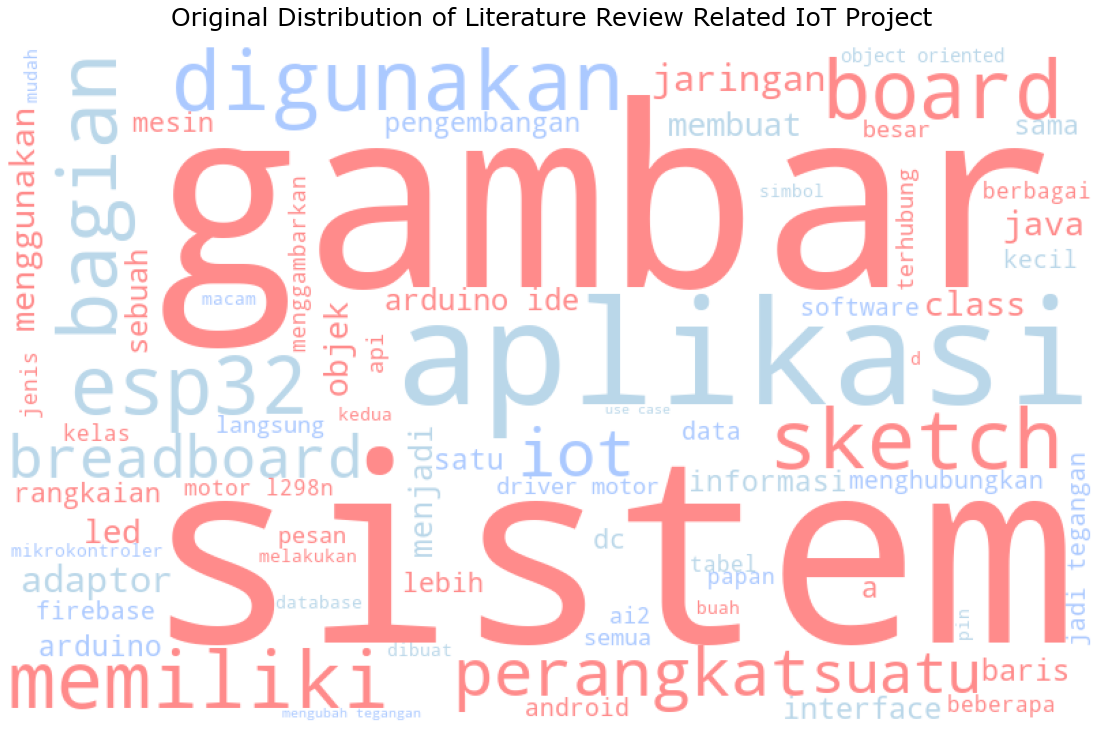

In [49]:
# Extract sentence and clean unstructurize word using regex
list_description = [regex_cleaning(doc.page_content) for doc in docs]

# Create Wordcloud Visualisation
generate_wordcloud(list_description, title = "Original Distribution of Literature Review Related IoT Project");